In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [7]:
import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir

import nibabel as nib

from scipy.stats import t as tdist
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)
from glob import glob

from collections import defaultdict, namedtuple


import matplotlib as mpl

In [9]:
eCON= '/data/bswift-1/Pessoa_Lab/eCON'

yoked = pd.read_excel(join(eCON,'onsetdir/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1').reset_index()

In [10]:
shock_beta_path = eCON+'/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_{roi}/noProx/shock_deconv/{subj}_bucket_REML_clean.1D'

In [11]:
rois = {'lBNST': 'Left BNST',
        'ldAI':'Left Dorsal Anterior Insual',
        'lPa': 'Left Anterior Putamen',
        'lvAI':'Left Ventral Anterior Insula',
        'rBNST': 'Right BNST',
        'lVS': 'Left Ventral Striatum',
        'rPa': 'Right Anterior Putamen',
        'rCa': 'Right Anterior Caudate',
        'rdAI':'Right Dorsal Anterior Insula',
        'Amygdala_BLBM_La_L': 'Left Amygdala (BLBM+La)',
        'rvAI':'Right Ventral Anterior Insula',
        'Amygdala_CeME_L': 'Left Central Amygdala',
        'Amygdala_BLBM_La_R': 'Right Amygdala (BLBM_La)',
        'rVS': 'Right Ventral Striatum',
        'lCa': 'Left Anterior Caudate',
        'lPAG1':'Left PAG',
        'ACC': 'Anterior Cingulate',
        'Amygdala_CeME_R': 'Right Central Amygdala',
        'lPI': 'Left Posterior Insula',
        'rPAG1':'Right PAG',
        'vmPFC':'vmPFC',
        'rPI': 'Right Posterior Insula',
        'PCC1':'PCC1',
        'PCC2':'PCC2'}

In [12]:
len(list(rois.keys()))

24

In [13]:
if exists('EstimatedShockResp.txt'):
    df = pd.read_csv('EstimatedShockResp.txt')
else:
    df = pd.DataFrame()
    for i, row in yoked.iterrows():
        for group in 'control uncontrol'.split():
            for roi in rois.keys():
                response = np.loadtxt(shock_beta_path.format(subj=row[group],group=group,roi=roi))[25::2]
                tmp_df = pd.DataFrame(response,columns=['Response'])
                tmp_df['ROI'] = rois[roi]
                tmp_df['Time'] = np.arange(response.size)*1.25
                tmp_df['SubjID'] = row[group]
                tmp_df['Group'] = group
                tmp_df['Pair'] = 'P{:02d}'.format(i)
                df = pd.concat([df,tmp_df],axis = 0)
    df.to_csv('EstimatedShockResp.txt',sep=',',index=False)

In [14]:
df.head()

,Response,ROI,Time,SubjID,Group,Pair
0,0.112296,Left BNST,0.00,CON001,control,P00
1,-1.065170,Left BNST,1.25,CON001,control,P00
2,0.443821,Left BNST,2.50,CON001,control,P00
3,0.211713,Left BNST,3.75,CON001,control,P00
4,1.000830,Left BNST,5.00,CON001,control,P00


In [15]:
print('Total %d rois' %(len(list(df.ROI.unique()))))
N = len(df['Pair'].unique())
print('Total %d yoke pairs' %(N))

Total 24 rois
Total 61 yoke pairs


In [16]:
cross_subj_mean_df = df.groupby(['Time','ROI','Group'])['Response'].mean().reset_index()

from scipy.stats import sem
cross_subj_se_df = df.groupby(['Time','ROI','Group'])['Response'].agg(sem).reset_index()

In [19]:
from scipy.stats import t as tdist

critT = tdist(df=N-1).ppf(0.975)
t = df.Time.unique()
cmap = plt.get_cmap('Set1')
HRF = np.loadtxt(join(eCON,'scripts/tmp_preproc2/canonical_reps_dur0.9557145s.1D'))

# Visualizing estimated shock responses for both groups

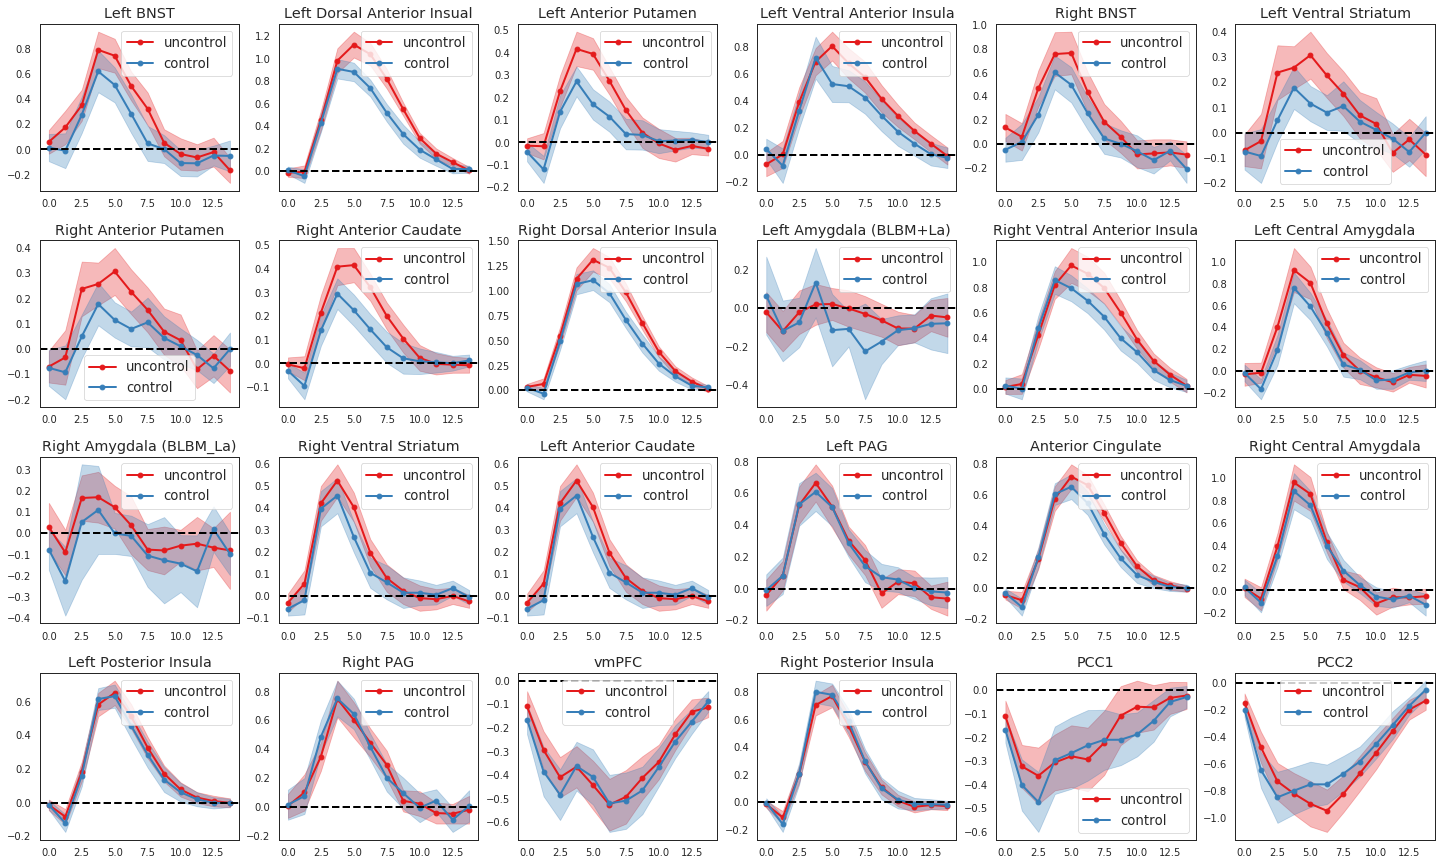

In [20]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig, axes = plt.subplots(nrows=4, ncols=6, sharey=False, figsize=(25,15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3,wspace=0.2)
for i,roi in enumerate(rois.values()):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    axes[i].plot(t,uncon_mean, color=cmap.colors[0],linewidth=2,marker='o',label='uncontrol')
    axes[i].fill_between(t,uncon_mean-(critT*uncon_se),
                         uncon_mean+(critT*uncon_se),
                         alpha=0.3,
                         color=cmap.colors[0])
    
    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    
    axes[i].plot(t,con_mean, color=cmap.colors[1],linewidth=2,marker='o',label='control')
    axes[i].fill_between(t,con_mean-(critT*con_se),
                         con_mean+(critT*con_se),
                         alpha=0.3,
                         color=cmap.colors[1])
    
    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    axes[i].set_title(roi)
    axes[i].legend()

#fig.savefig('figures/estimated_shock_response.png',dpi=600)

# Visualizing estimated response just single ROI

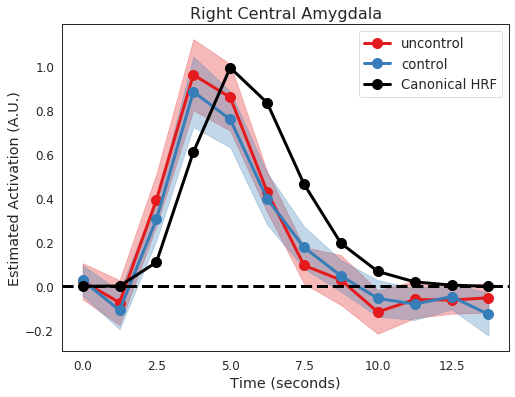

In [21]:
roi = 'Right Central Amygdala'
uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                            & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values

plt.figure(figsize=(8,6))
plt.plot(t,uncon_mean, color=cmap.colors[0],linewidth=3,marker='o',label='uncontrol',markersize=10)
plt.fill_between(t,uncon_mean-(critT*uncon_se),
                     uncon_mean+(critT*uncon_se),
                     alpha=0.3,
                     color=cmap.colors[0])

con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values
con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values


plt.plot(t,con_mean, color=cmap.colors[1],linewidth=3,marker='o',label='control',markersize=10)
plt.fill_between(t,con_mean-(critT*con_se),
                     con_mean+(critT*con_se),
                     alpha=0.3,
                     color=cmap.colors[1])

plt.plot(t,HRF,color='black',linewidth=3,marker='o',label='Canonical HRF',markersize=10)

plt.axhline(y=0,linestyle='--',linewidth=3,c='black')
plt.xticks(t[0::2],fontsize=12)
plt.yticks(fontsize=12)
plt.title(roi,fontsize=16)
plt.xlabel('Time (seconds)')
plt.ylabel('Estimated Activation (A.U.)')
plt.legend()
#plt.savefig('figures/estimated_shock_response_right_central_amygdala.png')

## Visualizing the difference in slopes

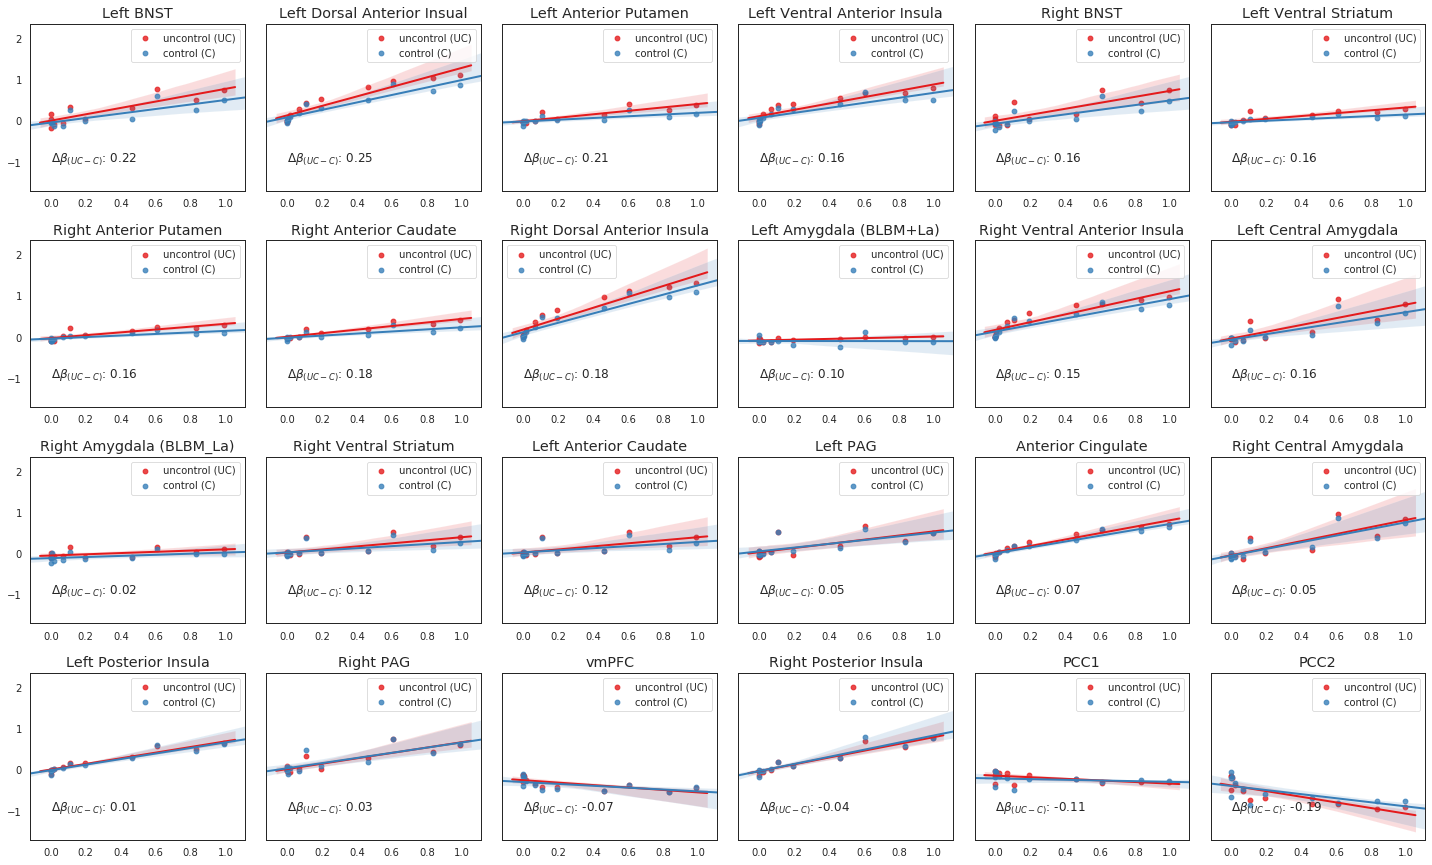

In [22]:
from scipy.stats import linregress

fig, axes = plt.subplots(nrows=4, ncols=6, sharey=True, figsize=(25,15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3,wspace=0.1)
for i,roi in enumerate(rois.values()):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    sns.regplot(HRF,uncon_mean,color=cmap.colors[0],marker='o',line_kws=dict(linewidth=2),label='uncontrol (UC)',ax=axes[i])
    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    sns.regplot(HRF,con_mean,color=cmap.colors[1],marker='o',line_kws=dict(linewidth=2),label='control (C)',ax=axes[i])
    
    slope_uncon, intercept_uncon, r_value_uncon, p_value_uncon, std_err_uncon = linregress(x=axes[i].get_lines()[0].get_xdata(),y=axes[i].get_lines()[0].get_ydata())
    slope_con, intercept_con, r_value_con, p_value_con, std_err_con = linregress(x=axes[i].get_lines()[1].get_xdata(),y=axes[i].get_lines()[1].get_ydata())
    
    axes[i].text(0,-1,r'$\Delta\beta_{(UC-C)}$: %.2f' %(slope_uncon-slope_con),fontsize=12)
    
    axes[i].set_title(roi)
    axes[i].legend(fontsize=10)

#fig.savefig('figures/slopes_estimated_shock_response.png',dpi=600)

## Plotting difference within each yoked pair

In [23]:
df[df['Group']=='control'].head()

,Response,ROI,Time,SubjID,Group,Pair
0,0.112296,Left BNST,0.00,CON001,control,P00
1,-1.065170,Left BNST,1.25,CON001,control,P00
2,0.443821,Left BNST,2.50,CON001,control,P00
3,0.211713,Left BNST,3.75,CON001,control,P00
4,1.000830,Left BNST,5.00,CON001,control,P00


In [24]:
df[df['Group']=='uncontrol'].head()

,Response,ROI,Time,SubjID,Group,Pair
0,1.174600,Left BNST,0.00,CON031,uncontrol,P00
1,0.444063,Left BNST,1.25,CON031,uncontrol,P00
2,-0.481784,Left BNST,2.50,CON031,uncontrol,P00
3,1.928820,Left BNST,3.75,CON031,uncontrol,P00
4,1.412790,Left BNST,5.00,CON031,uncontrol,P00


## Creating paired difference df

In [25]:
paired_df = pd.DataFrame()
for i,row in yoked.iterrows():
    for roi in rois.values():
        uc_resp = df[(df['Pair'] == 'P{:02d}'.format(i)) & (df['SubjID']==row['uncontrol']) & (df['ROI']==roi)]['Response'].values
        c_resp = df[(df['Pair'] == 'P{:02d}'.format(i)) & (df['SubjID']==row['control']) & (df['ROI']==roi)]['Response'].values
        
        tmp_df = pd.DataFrame({'Time':list(np.arange(uc_resp.size)*1.25),
                               'ROI':roi,
                               'Response':uc_resp-c_resp})
        paired_df = pd.concat([paired_df,tmp_df],axis=0)

In [26]:
paired_df.shape

(17568, 3)

In [27]:
paired_df.head()

,Time,ROI,Response
0,0.00,Left BNST,1.062304
1,1.25,Left BNST,1.509233
2,2.50,Left BNST,-0.925605
3,3.75,Left BNST,1.717107
4,5.00,Left BNST,0.411960


In [28]:
cross_pair_mean_df = paired_df.groupby(['ROI','Time']).mean().reset_index()
cross_pair_mean_df.head()

,ROI,Time,Response
0,Anterior Cingulate,0.00,-0.013282
1,Anterior Cingulate,1.25,0.044345
2,Anterior Cingulate,2.50,-0.010646
3,Anterior Cingulate,3.75,-0.028665
4,Anterior Cingulate,5.00,0.065432


In [29]:
cross_pair_se_df = paired_df.groupby(['ROI','Time']).agg(sem).reset_index()
cross_pair_se_df.head()

,ROI,Time,Response
0,Anterior Cingulate,0.00,0.023197
1,Anterior Cingulate,1.25,0.040354
2,Anterior Cingulate,2.50,0.041854
3,Anterior Cingulate,3.75,0.045307
4,Anterior Cingulate,5.00,0.049023


## Compare with the assummed shape estimates

In [30]:
df_MR = pd.read_csv(join(eCON,'dataset/data_for_RBA/uncon_v_con_shock_MR.txt'),sep='\t')

In [31]:
from scipy.stats import ttest_1samp

In [32]:
ttest_table = pd.DataFrame()
for roi in rois.keys():
    samp = df_MR[df_MR['ROI']==roi]['Y'].values
    tstat, p = ttest_1samp(samp,0)
    tmp_df = pd.DataFrame([roi,np.round(tstat,8), np.round(p,8)],index=['ROI','t-stat','p-value']).T
    ttest_table = pd.concat([ttest_table,tmp_df],axis =0)

In [33]:
ttest_table.sort_values('p-value')

,ROI,t-stat,p-value
0,lPa,3.88684,0.00025639
0,ldAI,3.36311,0.00134682
0,rCa,3.12721,0.00272137
0,lVS,2.62302,0.011033
0,rPa,2.62302,0.011033
0,lBNST,2.54891,0.0133817
0,rdAI,2.12838,0.0374216
0,lvAI,2.06492,0.0432602
0,lCa,1.91008,0.0609064
0,rVS,1.91008,0.0609064


/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


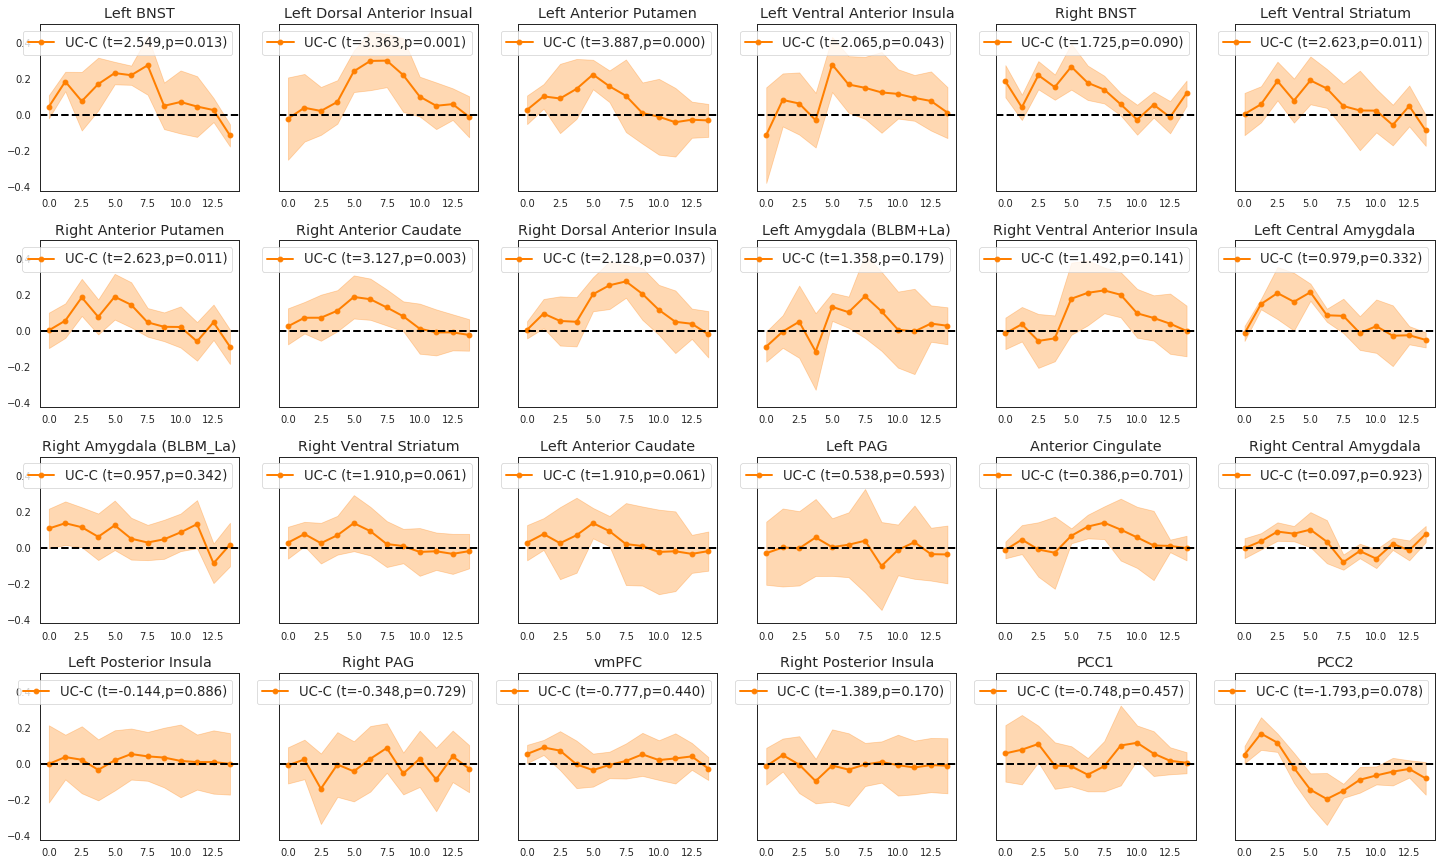

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=6, sharey=True, figsize=(25,15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.3,wspace=0.2)
for i,roi in enumerate(rois.keys()):
    
    pair_mean = cross_pair_mean_df[cross_pair_mean_df['ROI']==rois[roi]]['Response'].values
    pair_se = cross_pair_se_df[cross_subj_se_df['ROI']==rois[roi]]['Response'].values
    
    tstat, p = ttest_table[ttest_table['ROI']==roi].values[0][1:].tolist()
    axes[i].plot(t,pair_mean, color=cmap.colors[4],linewidth=2,marker='o',label='UC-C (t=%.3f,p=%.3f)'%(tstat,p))
    axes[i].fill_between(t,pair_mean-(critT*pair_se),
                         pair_mean+(critT*pair_se),
                         alpha=0.3,
                         color=cmap.colors[4])
    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    axes[i].set_title(rois[roi])
    axes[i].legend()

#fig.savefig('figures/uncon_v_con_estimated_shock_response.png',dpi=600)

# Creating inset plot 

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


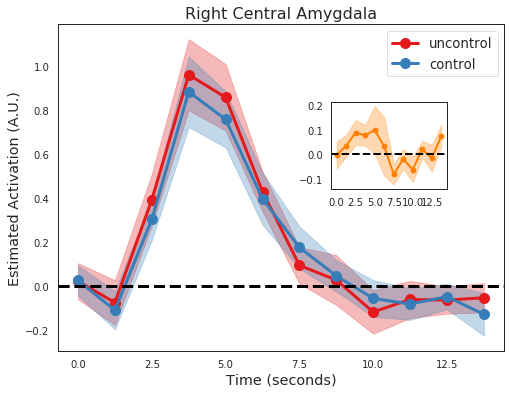

In [35]:
roi = 'Right Central Amygdala'
uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                            & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values

fig, ax1 = plt.subplots(figsize=(8,6),sharey=True)

right, top, width, heigh = [0.6,0.5,0.2,0.2]
ax2 = fig.add_axes([right,top,width,heigh])


ax1.plot(t,uncon_mean, color=cmap.colors[0],linewidth=3,marker='o',label='uncontrol',markersize=10)
ax1.fill_between(t,uncon_mean-(critT*uncon_se),
                     uncon_mean+(critT*uncon_se),
                     alpha=0.3,
                     color=cmap.colors[0])

con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values
con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                              & (cross_subj_mean_df['Group']=='control')]['Response'].values


ax1.plot(t,con_mean, color=cmap.colors[1],linewidth=3,marker='o',label='control',markersize=10)
ax1.fill_between(t,con_mean-(critT*con_se),
                     con_mean+(critT*con_se),
                     alpha=0.3,
                     color=cmap.colors[1])



ax1.axhline(y=0,linestyle='--',linewidth=3,c='black')
ax1.set_xticks(t[0::2])
#ax1.set_yticks()
ax1.set_title(roi,fontsize=16)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Estimated Activation (A.U.)')
ax1.legend()



### Inset
pair_mean = cross_pair_mean_df[cross_pair_mean_df['ROI']==roi]['Response'].values
pair_se = cross_pair_se_df[cross_subj_se_df['ROI']==roi]['Response'].values

#tstat, p = ttest_table[ttest_table['ROI']==roi].values[0][1:].tolist()
ax2.plot(t,pair_mean, color=cmap.colors[4],linewidth=2,marker='o',label='UC-C (t=%.3f,p=%.3f)'%(tstat,p))
ax2.fill_between(t,pair_mean-(critT*pair_se),
                     pair_mean+(critT*pair_se),
                     alpha=0.3,
                     color=cmap.colors[4])

ax2.axhline(y=0,linestyle='--',linewidth=2,c='black')
ax2.set_xticks(t[::2])
#ax2.set_title(roi)
#ax2.legend()
#plt.savefig('figures/estimated_shock_response_right_central_amygdala.png')

/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


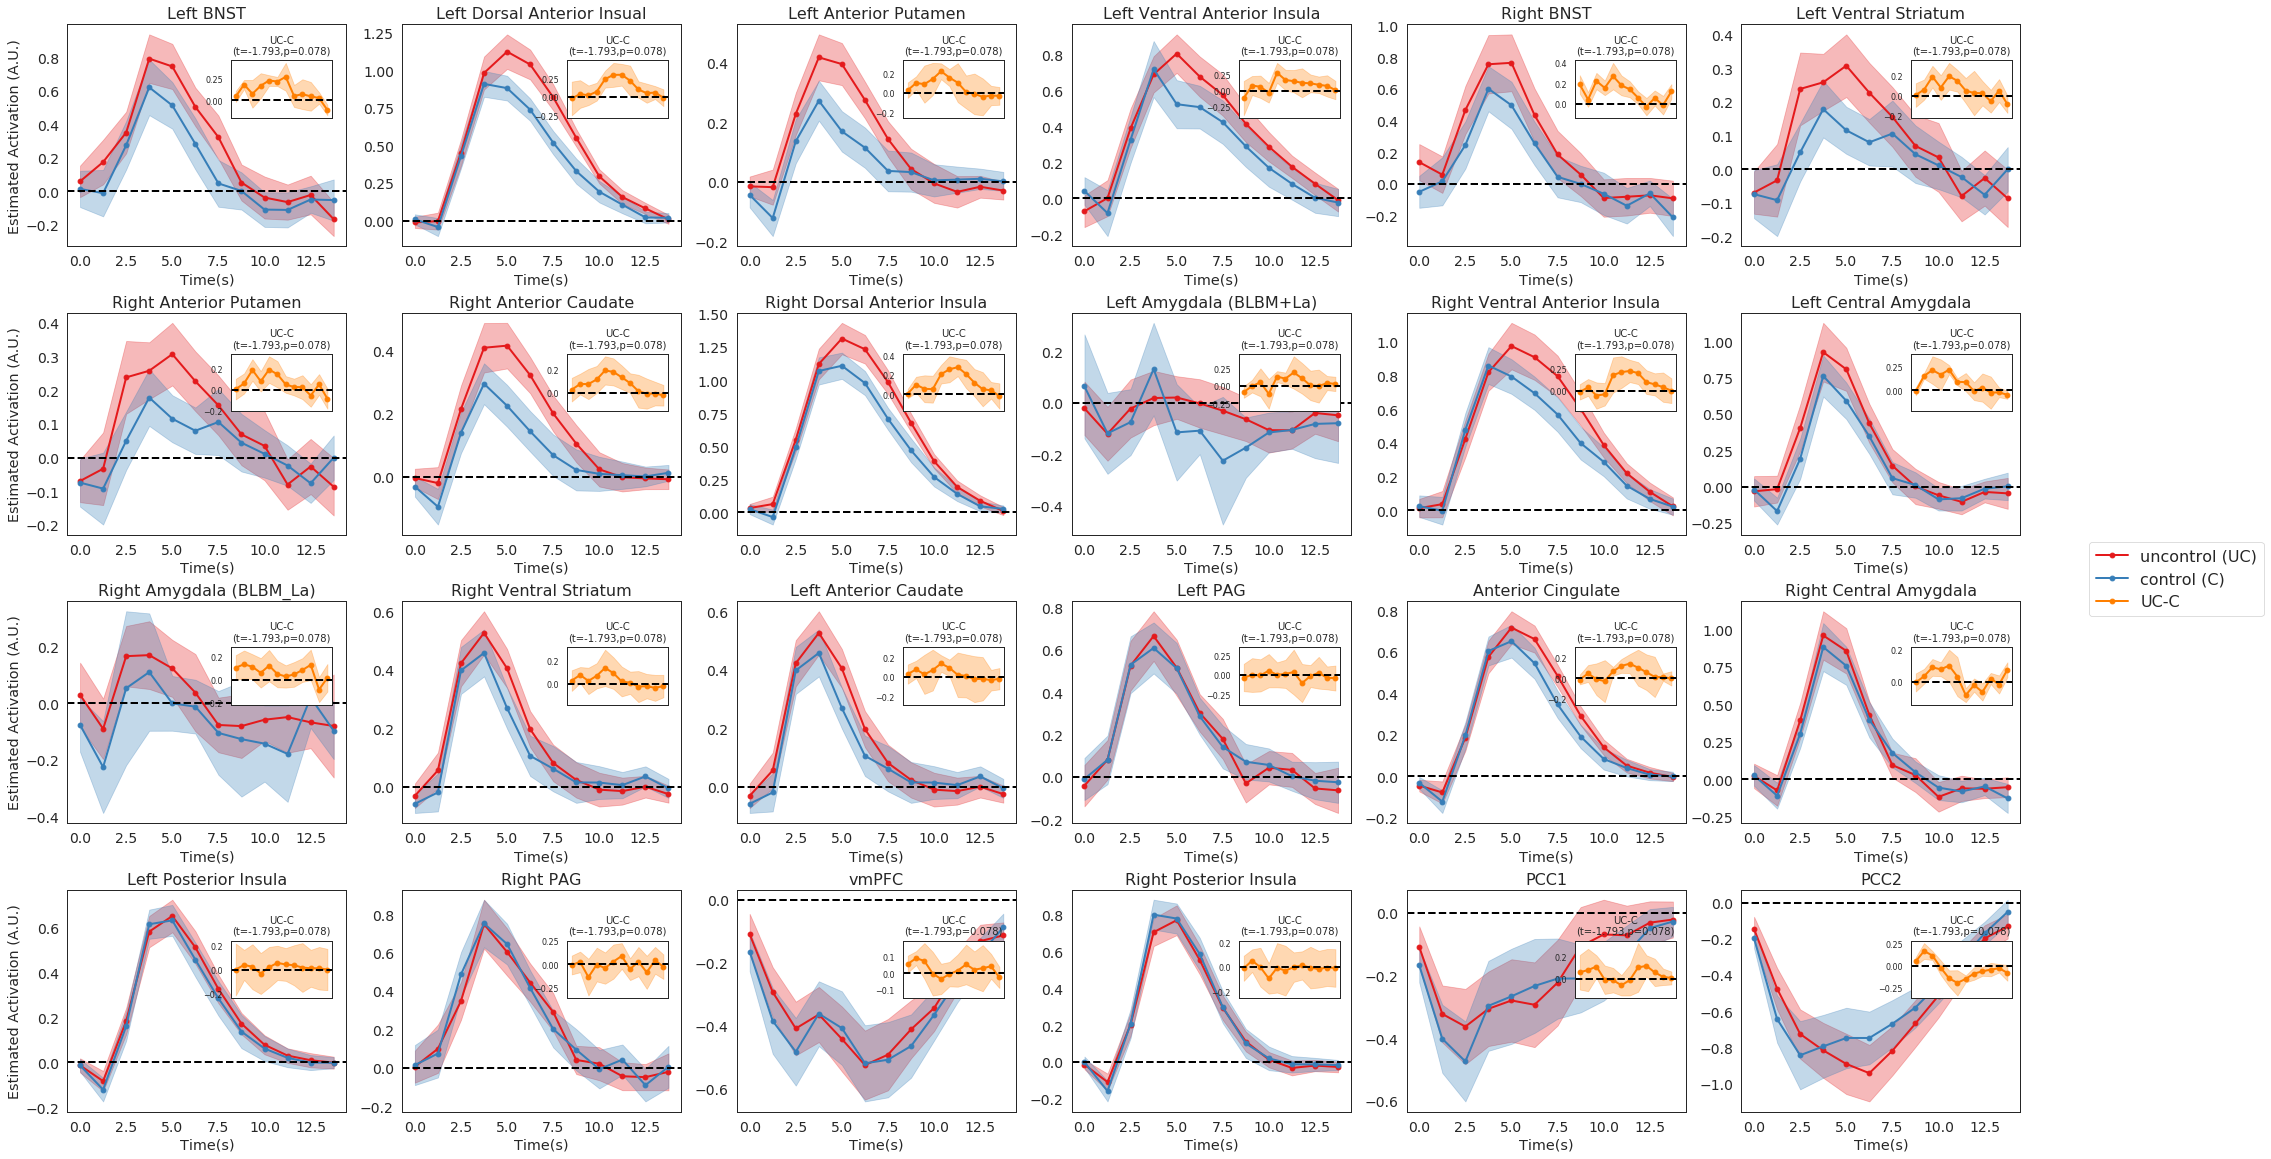

In [36]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

fig, axes = plt.subplots(nrows=4, ncols=6, sharey=False, figsize=(35,20))
axes = axes.flatten()

FIGWIDTH = fig.get_figwidth()
FIGHEIGHT = fig.get_figwidth()
k_cols = 6
k_rows = 4

fig.subplots_adjust(hspace=0.3,wspace=0.2)

right, top, width, heigh = [0.19,0.815,0.04,0.04]

for i,roi in enumerate(rois.values()):
    
    uncon_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                    & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    uncon_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                & (cross_subj_mean_df['Group']=='uncontrol')]['Response'].values
    
    axes[i].plot(t,uncon_mean, color=cmap.colors[0],linewidth=2,marker='o',label='uncontrol (UC)')
    axes[i].fill_between(t,uncon_mean-(critT*uncon_se),
                         uncon_mean+(critT*uncon_se),
                         alpha=0.3,
                         color=cmap.colors[0])
    
    
    con_mean = cross_subj_mean_df[(cross_subj_mean_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    con_se = cross_subj_se_df[(cross_subj_se_df['ROI']==roi)\
                                  & (cross_subj_mean_df['Group']=='control')]['Response'].values
    
    
    axes[i].plot(t,con_mean, color=cmap.colors[1],linewidth=2,marker='o',label='control (C)')
    axes[i].fill_between(t,con_mean-(critT*con_se),
                         con_mean+(critT*con_se),
                         alpha=0.3,
                         color=cmap.colors[1])
    
    
    axes[i].axhline(y=0,linestyle='--',linewidth=2,c='black')
    axes[i].set_xticks(t[::2])
    axes[i].set_title(roi,fontsize=16)
    axes[i].set_xlabel('Time(s)')
    
    row = int(i/k_cols)
    col = (i%k_cols)
    
    if col == 0:
        axes[i].set_ylabel('Estimated Activation (A.U.)')
    
    ### Inset
    
   
    
    #if i == 0:
    ax2 = fig.add_axes([right+(right*col/1.425),top-(top*row/4),width,heigh])

    pair_mean = cross_pair_mean_df[cross_pair_mean_df['ROI']==roi]['Response'].values
    pair_se = cross_pair_se_df[cross_subj_se_df['ROI']==roi]['Response'].values

    #tstat, p = ttest_table[ttest_table['ROI']==roi].values[0][1:].tolist()
    ax2.plot(t,pair_mean, color=cmap.colors[4],linewidth=2,marker='o',label='UC-C')
    ax2.fill_between(t,pair_mean-(critT*pair_se),
                         pair_mean+(critT*pair_se),
                         alpha=0.3,
                         color=cmap.colors[4])
    ax2.set_xticks([])
    #ax2.set_xlabel('Time',fontsize=8)
    ax2.tick_params(axis="y", labelsize=8) 
    ax2.axhline(y=0,linestyle='--',linewidth=2,c='black')
    ax2.set_title('UC-C\n(t=%.3f,p=%.3f)'%(tstat,p),fontsize=10)
    
    

main_legend_handles, main_legend_labels = axes[i].get_legend_handles_labels()
inset_legend_handles, inset_legend_labels = ax2.get_legend_handles_labels()
fig.legend(main_legend_handles+inset_legend_handles,main_legend_labels+inset_legend_labels,loc='center right',fontsize=16)
#plt.figlegend(main_legend_handles+inset_legend_handles,main_legend_labels+inset_legend_labels, loc='right',bbox_to_anchor=(1, 0.5)))
#fig.savefig('figures/estimated_shock_response.png',dpi=600)